## Analytics for All Runs


In [1]:
import numpy as np       # operations on numerical arrays
import math as m
import operator          # for sorting list of class instances
from scipy import stats
import datetime as dt
from   dateutil import parser 


import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import matplotlib as mpl

from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

from IPython.display import display, Markdown, Latex

import runData as rd


Starting Date:  2012-12-10 00:00:00 <class 'datetime.datetime'>
Ending Date:    2022-01-19 00:00:00 <class 'datetime.datetime'>


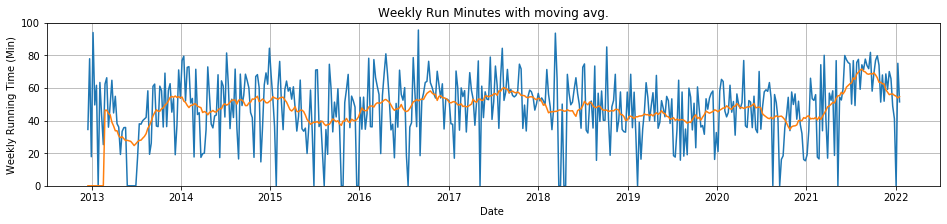

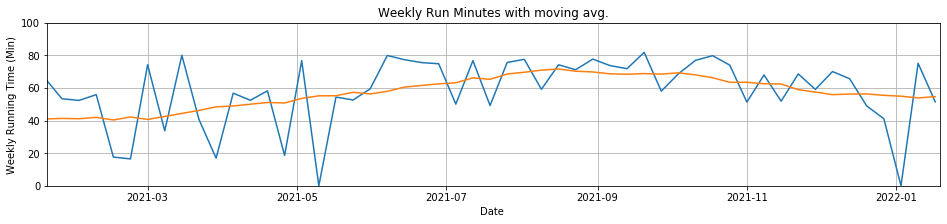

In [2]:
# Testing Time range
#
#
DEBUGGING = False
TR_n = 30
TR_ctr = parser.parse('12-Nov-2015')
TR_1  = TR_ctr - dt.timedelta(days=TR_n)
TR_2  = TR_ctr + dt.timedelta(days=TR_n)
# most recent
TR_2 = dt.datetime.now()
TR_1 = TR_2 - dt.timedelta(days=30)
#TR_specRuns = []

if not DEBUGGING:
    t = TR_1
    TR_1 = TR_2
    TR_2 = t    # impossible to match!

def plot_run_rate(runs, Nsm):  # plot minutes per week vs time
    # runs must be in original file order: most recent first.
    # Nsm = smoothing window SHOULD BE ODD
    if Nsm%2 != 1:
        print('Smoothing windown must be odd! (fixing: Nsm={:})'.format(Nsm))
        Nsm += 1
    TR_dtot = 0

    ##############################################   Plot Pace vs Time
    plt.figure(2,figsize=(16,3))
    #plt.rcParams["figure.figsize"] = (20,10)

    MONDAY = 0
    AWEEK = dt.timedelta(days=7)
    ADAY  = dt.timedelta(days=1)
    startdate = runs[0].date
    enddate   = runs[-1].date
    while startdate.weekday() > MONDAY:
        startdate -= ADAY 

    print("Starting Date: ",startdate,type(startdate))
    print("Ending Date:   ",  enddate,type(enddate))
    
    n=0
    wk_time = 0
    dates = []
    times = []
    
    day = startdate-ADAY
    nextdate = startdate + AWEEK - ADAY
    r=0
    while True:  
        n+=1
        day += ADAY
        if r>=len(runs)-1:
            break
        while (runs[r].date.date() == day.date()):
            wk_time += (runs[r].dur)/60.0
            r += 1
        if day > nextdate:  # end of 7 days
            dates.append(day)
            times.append(wk_time)
            wk_time = 0
            nextdate += AWEEK
        if day > TR_1 and day < TR_2:
            print('{:3d}:{:} --[{:8.1f}]-- ==[{:}]== match: {:}'.format(n,day.date(), wk_time, nextdate, flag))
            
    if(False):
        print(' relevant data slice:')
        for r in runs:
            day = r.date
            if day > TR_1 and day < TR_2:
                print(r)

    plt.plot(dates, times)

# since data is most recent first, smooth a reversed array:
    rtimes = times.copy()
    rtimes.reverse() # in place
    revtimes = np.array(rtimes)
    if len(times) > 2*Nsm:
        sm = np.flip(rd.smooth(revtimes, Nsm, 'flat'),0)  # flip = unreverse to match most-recent-first
        #print "Data is smoothed ", sm.shape 
        #fix glitch in last (most recent) pt
        sm[0]= sm[1] #hack
        # try to shift smoothed for better match
        shift = int((Nsm-1)/2)
        prefix = np.array([0]*shift)
        sm1 = np.concatenate((prefix,sm.copy()[:-shift]))
        plt.plot(dates, sm1)
        plt.title('Weekly Run Minutes with moving avg.')
    else:
        plt.title('Weekly Run Minutes')
    plt.xlabel('Date ')
    plt.ylabel('Weekly Running Time (Min)')
    plt.grid([1,1])
    plt.ylim([0,100])
    
    ####################################################################
    #  zoomed in plot
     ##############################################   Plot Pace vs Time
    plt.figure(3,figsize=(16,3))
    plt.plot(dates,times) # raw times
    plt.plot(dates,sm1)  # smoothed times
    plt.xlim([runs[-1].date-dt.timedelta(days=365),runs[-1].date+dt.timedelta(days=0)])
    plt.title('Weekly Run Minutes with moving avg.') 
    plt.xlabel('Date ')
    plt.ylabel('Weekly Running Time (Min)')
    plt.grid([1,1])
    plt.ylim([0,100])
    
    
    plt.show()
 
runs1 = rd.runLists()
runs1.reader()  # get the data

WINDOW = 21  # runs
r3 = sorted(runs1.allruns,key=lambda x: x.date, reverse=False)
plot_run_rate(r3,WINDOW)

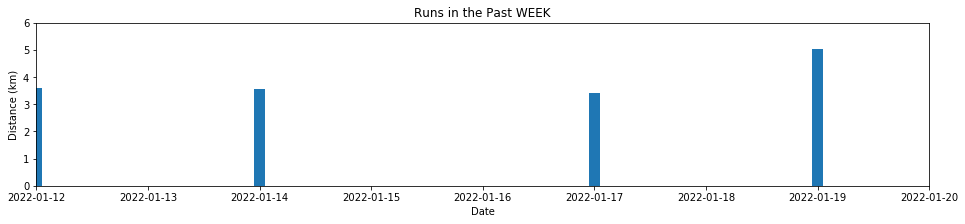

In [3]:
# Most recent week
 
today = dt.date.today()
wstart = today - dt.timedelta(days=7)

rtw = []  # runs this week
for i,r in enumerate(r3):
    if r3[i].date.date() >= wstart:
        rtw.append(r)
        
def plot_week(wruns):
    dates=[]
    dists=[]
    for r in wruns:
        dates.append(r.date)
        dists.append(r.dist())
    ##############################################   Plot Bar Graph: distance each date
    fig = plt.figure(figsize=(16,3))
    ax = fig.add_subplot(111)
    ax.bar(dates,dists,width=0.1)
    ax.xaxis_date()
    ax.set_ylim(0,6)
    ax.set_xlim(dt.date.today()-dt.timedelta(days=7), dt.date.today()+dt.timedelta(days=1))
    ax.set_xlabel('Date')
    ax.set_ylabel('Distance (km)')
    ax.set_title('Runs in the Past WEEK')
    plt.show()
    
plot_week(rtw)

In [4]:
thisintervalruns = {}
timethisinterval = {}
kmthisinterval = {}
ttot = 0.0
kmtot = 0.0
dmax=parser.parse('1-jan-1900')
dmin=parser.parse('1-jan-2999')
daysintervals = [7,31, 60,182]

# clear out the data
for di in daysintervals:
    timethisinterval[di] = 0
    kmthisinterval[di] = 0
    
#r3 = runs1.allruns
for r in r3:  # get min and max dates
  if r.date > dmax:
        dmax = r.date
  if r.date < dmin:
        dmin = r.date

reportingtime = dt.datetime.now()
TR_dtot = 0
for r in r3: 
    #print('what the ..?', r.dur)
    # Time Range TR Testing
    if r.date < TR_2 and r.date > TR_1:
            TR_dtot += r.dur/60.0
            print('             table: {:<75.75} TR_dtot: {:9.1f}min'.format(str(r),TR_dtot)) 
            
 #   if dt.datetime.now()-r.date < dt.timedelta(days=180):
 #       print(r.date, r.dur, r.dist())
    for di in daysintervals:
        if  reportingtime-r.date <= dt.timedelta(days=di):
            timethisinterval[di] += r.dur
            kmthisinterval[di]   += r.dist()
     #       print("a run this month: ", r.date,timethisinterval, kmthisinterval)
        
#
#   Output stats in a markdown table
#
tb_head = '|---|---|---|---|---|'
table = ''
row = '|'

def addrow(table,row):
    table += '\n' + row
    return table

def mdo(mdst):
    display(Markdown(mdst))
    
####      generate a markdown table of output
######### daily avg stats    

mdo('\n #### Daily Average Table: '+str(reportingtime))
row += 'last x Days:    |'
for di in daysintervals: 
        row += '  {:d}  |'.format(di)
table = addrow(table,row)
table += '\n' + tb_head
row = '| Running Time:  | '
for di in daysintervals:
    row += ' {:4.1f}min |'.format( (timethisinterval[di]/60)/di)
table = addrow(table,row)
row = '| Distance (km) |'
for di in daysintervals:
    row += ' {:3.1f}km |'.format( kmthisinterval[di]/di) 
table = addrow(table,row)
 
mdo(table)



 #### Daily Average Table: 2022-01-19 17:00:56.471018


|last x Days:    |  7  |  31  |  60  |  182  |
|---|---|---|---|---|
| Running Time:  |   8.3min |  6.7min |  7.8min |  9.2min |
| Distance (km) | 1.7km | 1.4km | 1.6km | 1.9km |

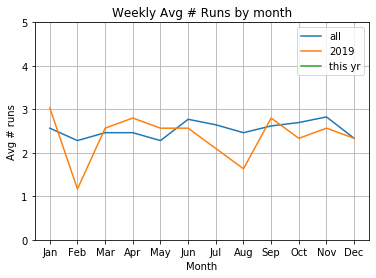

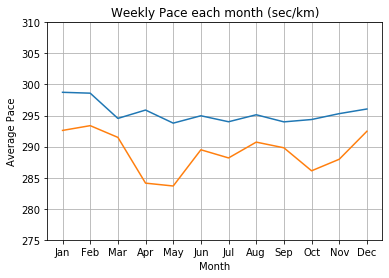

Ending:  2022-01-19 00:00:00 ,
1182 (allruns)
 999 (runs)
most recent record:  2022-01-17  3.4km  288.1sec/km     16.3min 12:10, 44F, partly cloudy         0.0F


In [7]:


def plot_run_permo(runs):  # plot #runs and pace per month of the year
    ##############################################   Plot Pace vs Time
    plt.figure()
    #plt.rcParams["figure.figsize"] = (20,10)


    n=0
    wk_time = 0
    dates = []
    times = []
    
    thisyear = int(dt.date.today().year)
    thisyear = 2022
     
    month_times = np.zeros(12)  # durations
    month_n     = np.zeros(12)  # num of runs
    month_yrs   = list([set() for _ in range(12)]) # list of sets of yrs of data for each month
    month_ny    = np.zeros(12)  # num yrs of data for that mo.
    month_pace  = np.zeros(12)  # pace -> avg pace
    month_names = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
    
    moty_times = np.zeros(12)    # stats for this year
    moty_n     = np.zeros(12)
    moty_pace  = np.zeros(12)
    #
    mo19_times = np.zeros(12)
    mo19_n     = np.zeros(12)
    mo19_pace = np.zeros(12)
    
    MONDAY = 0
    startdate = runs[0].date
   # while startdate.weekday() > MONDAY:
   #     startdate -= dt.timedelta(days=1)
   # nextdate = startdate + dt.timedelta(days=7)
    yrprev = 0
    for r in runs:
        yr = int(r.date.year)
        mo = int(r.date.month)  # 
     
        #  add this year to this months set
        month_yrs[mo-1].add(yr)  # track which years of data for this mo.
        month_times[mo-1] += r.dur  # add duration to the month bin
        month_n[mo-1] += 1          # count runs in this month
        month_pace[mo-1] += r.pace
        
        if yr == thisyear:
            moty_times[mo-1] += r.dur  # duration of runs
            moty_n[mo-1]     += 1
            moty_pace[mo-1]  += r.pace
            
        if yr == 2019:   # maybe my best running year of my life???
            mo19_times[mo-1] += r.dur  # duration of runs
            mo19_n[mo-1]     += 1
            mo19_pace[mo-1]  += r.pace
             

    for i in range(12):
        if(0):
            print (month_names[i],": ",month_yrs[i], "   ", month_n[i])
        month_ny[i] = len(month_yrs[i])
    nmty = 0 #mo this year
    nm19 = 0 #mo in 2019
    # compute averages for each calendar month
    for i,p in enumerate(month_pace): # assume no months with 0 runs in 9 yrs(!)
        month_pace[i] = p/month_n[i] # avg pace that month
        # this year we WILL have zeros.
        if moty_n[i] != 0:
            nmty += 1  # how many running months this year?
            moty_pace[i]  = moty_pace[i]/moty_n[i]
            moty_times[i] = moty_times[i]/moty_n[i]
        else:
            moty_pace[i] = 310  #default
            moty_times[i] = 0
        #  same analysis for 2019 specifically (my PRIME!)
        if mo19_n[i] != 0:
            nm19 += 1  # how many running months this year?
            mo19_pace[i]  = mo19_pace[i]/mo19_n[i]
            mo19_times[i] = mo19_times[i]/mo19_n[i]
        else:
            mo19_pace[i] = 310  #default
            mo19_times[i] = 0
            
        # avg duration per month    
        month_n[i] = month_n[i]/month_ny[i]    # average runs in month i per year
            
    # plot data 
    plt.plot(month_names, month_n*(7/30), month_names, mo19_n*(7/30), month_names[0:nmty], moty_n[0:nmty]*(7/30))
    plt.title("Weekly Avg # Runs by month")
    plt.xlabel('Month')
    plt.ylabel('Avg # runs')
    plt.legend(['all','2019','this yr'])

    plt.grid([1,1])
    plt.ylim([0,5])
    
    plt.figure()
    plt.plot(month_names, month_pace, month_names, mo19_pace, month_names[0:nmty], moty_pace[0:nmty])
    plt.title("Weekly Pace each month (sec/km)")
    plt.xlabel('Month')
    plt.ylabel('Average Pace')
 
    plt.grid([1,1])
    plt.ylim([275,310])
    plt.show()
    
plot_run_permo(runs1.allruns)

print("Ending: ",runs1.allruns[0].date, ",")
print('{:4d} (allruns)'.format(len(runs1.allruns)))
print('{:4d} (runs)'.format(len(runs1.runs)))
rr=runs1.runs[0]
print('most recent record: ',str(rr) )


In [6]:
print("Last Allrun: ", runs1.allruns[0])

Last Allrun:  2022-01-19  5.0km  283.8sec/km     23.9min 4:00pm, 48F, 80th to Dukes to     0.0F
